# Improts and setup

### Setup envirnonment 

In [1]:
%load_ext autoreload
%autoreload 2

### Import necessaary libraries

In [37]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image


import matplotlib as mpl
import matplotlib.pyplot as plt


import tempfile
from urllib.request import urlretrieve
import tarfile
import json
import imp
import os

import IPython.display as display
import PIL.Image


import numpy as np

### Import custom libraries

In [3]:
import patch_utils
import image_utils

In [4]:
imp.reload(patch_utils)
imp.reload(image_utils)

<module 'image_utils' from '/home/slavchic/Desktop/209AS_winter_2020/python_files/image_utils/__init__.py'>

# Workspace

### Load labels

In [5]:
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)### Choose an image

In [99]:
# specify training set
number_of_images = 5
my_classes = ['cat', 'ship']
my_valid_range = (0, 10)

# specify target class
target_class = 500

# specify the patch size, mean, std
mean = 0
std = 0.3
size = 150

# get train images 
train_set = image_utils.sample_images(my_classes, number_of_images, valid_range = my_valid_range)

### Patch setup

In [100]:
# patch creator
class patch_multiplier(layers.Layer):
    
    def __init__(self, patch_size=50, patch_mean=0, patch_std=0.3):
        super(patch_multiplier, self).__init__()
        self.patch_size = patch_size
        self.patch_mean = patch_mean
        self.patch_std = patch_std
        
    def build(self, input_shape):
        self.patch = self.add_weight(shape=(self.patch_size, self.patch_size, 3),
                                     initializer=tf.random_normal_initializer(mean=self.patch_mean, 
                                                                              stddev=self.patch_std, 
                                                                              seed=None),
                                     trainable=True,
                                     name='patch')
        
    def call(self, inputs):
        multiple_patches = tf.broadcast_to(self.patch, (tf.shape(inputs)[0], self.patch_size, self.patch_size, 3))
        return multiple_patches


# # patch wrinkle
# class patch_warp(layers.Layer):
    
#         def __init__(self):
#             super(patch_wrinkle, self).__init__()
            
#         def build(self, input_shape):
#             pass
        
#         def call(self, inputs):
#             output = tfa.image.dense_image_warp(inputs, flow)

    
    
# patch shift layer
# Note: order matters. First argument is patches, second has shape=[x_shift, y_shift]
class patch_shift(layers.Layer):
    
    def __init__(self):
        super(patch_shift, self).__init__()
        
    def build(self, input_shape):
        pass
    
    def call(self, inputs):    
        # get dimensions of the patch
        dims = tf.shape(inputs[0])

        # update patch lenth
        a = tf.concat((inputs[0], -2 * tf.ones(shape=(dims[0], dims[1], 299 - dims[2], 3), dtype=tf.float32)), axis=2)

        # update patch height
        b = tf.concat((a, -2 * tf.ones(shape=(dims[0], 299 - dims[1], 299, 3))), axis=1)

        # shift the patch to the place needed
        mapped_patches = tf.roll(b, shift = (inputs[1][0][0], inputs[1][0][1]), axis = (2, 1))

        return mapped_patches

    
    
    
    
# patch application layer
# Note: order matters. First argument is images, second is patches
class patch_applicator(layers.Layer):
    
    def __init__(self):
        super(patch_applicator, self).__init__()
        
    def build(self, input_shape):
        pass
    
    def call(self, inputs):
        # prepare a mask for original images
        img_mask = tf.math.abs(tf.math.add(tf.math.sign(tf.math.add(inputs[1], 2)), -1))
        # crop the place for the pathch
        cropped_images = tf.math.multiply(inputs[0], img_mask)

        # prepare a mask for patches
        patch_mask = tf.math.sign(tf.math.add(inputs[1], 2))

        # crop patch from the field of -2-s
        cropped_patch = tf.math.multiply(inputs[1], patch_mask)

        # get images with patches
        images_with_patches = cropped_images + cropped_patch
        
        return images_with_patches

### Graph setup

In [101]:
# clear previous session
tf.keras.backend.clear_session() 


# initialize inputs
input_image = tf.keras.layers.Input(shape=(299, 299, 3))
input_shift = tf.keras.layers.Input(shape=(2,), dtype=tf.int32)


# multiply patch
patch_multiplier_layer = patch_multiplier(patch_size=size)
patch_array = patch_multiplier_layer(input_image)


# shift patch
patch_shift_layer = patch_shift()
shifted_patch_array = patch_shift_layer([patch_array, input_shift])


# apply patch
patch_applicator_layer = patch_applicator()
adv_images = patch_applicator_layer([input_image, shifted_patch_array])


# declare submodel for convenience
image_processing_module = keras.models.Model(inputs=[input_image, input_shift], outputs=adv_images)


# declare inception and set it parameters as non-trainable
incv3 = tf.keras.applications.InceptionV3(weights="imagenet")
incv3.trainable=False


# connect output of submodel to the input of inception
out = incv3(image_processing_module.output)


# declare main model
adv_learning_model = keras.models.Model(inputs=[input_image, input_shift], outputs=out)

In [102]:
adv_learning_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
patch_multiplier (patch_multipl (None, 150, 150, 3)  67500       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
patch_shift (patch_shift)       (None, None, 299, 3) 0           patch_multiplier[0][0]           
                                                                 input_2[0][0]              

In [148]:
adv_learning_model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(learning_rate=1),
              metrics=[tf.metrics.Recall(class_id=500)])

In [149]:
nb_classes = 1000
targets = np.array([[500, 500, 500, 500, 500]]).reshape(-1)
one_hot_targets = np.eye(nb_classes)[targets].reshape(5, 1000)

shifts = np.ones(5*2).reshape(5, 2) * 50
train_setX = train_set[:, :299, :299] 

print('# Fit model on training data')
history = adv_learning_model.fit([train_setX[0:1], shifts[0:1]], one_hot_targets[0:1],
                    batch_size=1,
                    epochs=1500)

#print('\nhistory dict:', history.history)

# Fit model on training data
Train on 1 samples
Epoch 1/1500
1/1 [==============================] - 4s 4s/sample - loss: 5.6236 - recall_10: 0.0000e+00
Epoch 2/1500
1/1 [==============================] - 1s 580ms/sample - loss: 5.6086 - recall_10: 0.0000e+00
Epoch 3/1500
1/1 [==============================] - 1s 569ms/sample - loss: 5.5157 - recall_10: 0.0000e+00
Epoch 4/1500
1/1 [==============================] - 1s 588ms/sample - loss: 5.4355 - recall_10: 0.0000e+00
Epoch 5/1500
1/1 [==============================] - 1s 620ms/sample - loss: 5.3634 - recall_10: 0.0000e+00
Epoch 6/1500
1/1 [==============================] - 1s 566ms/sample - loss: 5.3064 - recall_10: 0.0000e+00
Epoch 7/1500
1/1 [==============================] - 1s 586ms/sample - loss: 5.2755 - recall_10: 0.0000e+00
Epoch 8/1500
1/1 [==============================] - 1s 581ms/sample - loss: 5.2413 - recall_10: 0.0000e+00
Epoch 9/1500
1/1 [==============================] - 1s 585ms/sample - loss: 5.2086 - recall_10: 0.0

Epoch 77/1500
1/1 [==============================] - 1s 656ms/sample - loss: 4.7175 - recall_10: 0.0000e+00
Epoch 78/1500
1/1 [==============================] - 1s 732ms/sample - loss: 4.7196 - recall_10: 0.0000e+00
Epoch 79/1500
1/1 [==============================] - 1s 597ms/sample - loss: 4.7100 - recall_10: 0.0000e+00
Epoch 80/1500
1/1 [==============================] - 1s 646ms/sample - loss: 4.7067 - recall_10: 0.0000e+00
Epoch 81/1500
1/1 [==============================] - 1s 731ms/sample - loss: 4.7035 - recall_10: 0.0000e+00
Epoch 82/1500
1/1 [==============================] - 1s 595ms/sample - loss: 4.6987 - recall_10: 0.0000e+00
Epoch 83/1500
1/1 [==============================] - 1s 635ms/sample - loss: 4.7006 - recall_10: 0.0000e+00
Epoch 84/1500
1/1 [==============================] - 1s 743ms/sample - loss: 4.7147 - recall_10: 0.0000e+00
Epoch 85/1500
1/1 [==============================] - 1s 871ms/sample - loss: 4.7134 - recall_10: 0.0000e+00
Epoch 86/1500
1/1 [=========

Epoch 153/1500
1/1 [==============================] - 1s 617ms/sample - loss: 4.6003 - recall_10: 0.0000e+00
Epoch 154/1500
1/1 [==============================] - 1s 705ms/sample - loss: 4.5955 - recall_10: 0.0000e+00
Epoch 155/1500
1/1 [==============================] - 1s 873ms/sample - loss: 4.5918 - recall_10: 0.0000e+00
Epoch 156/1500
1/1 [==============================] - 1s 950ms/sample - loss: 4.5927 - recall_10: 0.0000e+00
Epoch 157/1500
1/1 [==============================] - 1s 586ms/sample - loss: 4.5899 - recall_10: 0.0000e+00
Epoch 158/1500
1/1 [==============================] - 1s 646ms/sample - loss: 4.5838 - recall_10: 0.0000e+00
Epoch 159/1500
1/1 [==============================] - 1s 908ms/sample - loss: 4.5829 - recall_10: 0.0000e+00
Epoch 160/1500
1/1 [==============================] - 1s 620ms/sample - loss: 4.5866 - recall_10: 0.0000e+00
Epoch 161/1500
1/1 [==============================] - 1s 613ms/sample - loss: 4.5858 - recall_10: 0.0000e+00
Epoch 162/1500
1/1 

Epoch 229/1500
1/1 [==============================] - 1s 560ms/sample - loss: 4.5500 - recall_10: 0.0000e+00
Epoch 230/1500
1/1 [==============================] - 1s 577ms/sample - loss: 4.5436 - recall_10: 0.0000e+00
Epoch 231/1500
1/1 [==============================] - 1s 595ms/sample - loss: 4.5424 - recall_10: 0.0000e+00
Epoch 232/1500
1/1 [==============================] - 1s 769ms/sample - loss: 4.5440 - recall_10: 0.0000e+00
Epoch 233/1500
1/1 [==============================] - 1s 730ms/sample - loss: 4.5392 - recall_10: 0.0000e+00
Epoch 234/1500
1/1 [==============================] - 1s 636ms/sample - loss: 4.5414 - recall_10: 0.0000e+00
Epoch 235/1500
1/1 [==============================] - 1s 626ms/sample - loss: 4.5417 - recall_10: 0.0000e+00
Epoch 236/1500
1/1 [==============================] - 1s 1s/sample - loss: 4.5401 - recall_10: 0.0000e+00
Epoch 237/1500
1/1 [==============================] - 1s 1s/sample - loss: 4.5406 - recall_10: 0.0000e+00
Epoch 238/1500
1/1 [=====

Epoch 305/1500
1/1 [==============================] - 1s 693ms/sample - loss: 4.4995 - recall_10: 0.0000e+00
Epoch 306/1500
1/1 [==============================] - 1s 596ms/sample - loss: 4.4992 - recall_10: 0.0000e+00
Epoch 307/1500
1/1 [==============================] - 1s 689ms/sample - loss: 4.5067 - recall_10: 0.0000e+00
Epoch 308/1500
1/1 [==============================] - 1s 1s/sample - loss: 4.5126 - recall_10: 0.0000e+00
Epoch 309/1500
1/1 [==============================] - 1s 1s/sample - loss: 4.5044 - recall_10: 0.0000e+00
Epoch 310/1500
1/1 [==============================] - 1s 859ms/sample - loss: 4.4974 - recall_10: 0.0000e+00
Epoch 311/1500
1/1 [==============================] - 1s 720ms/sample - loss: 4.5054 - recall_10: 0.0000e+00
Epoch 312/1500
1/1 [==============================] - 1s 712ms/sample - loss: 4.5003 - recall_10: 0.0000e+00
Epoch 313/1500
1/1 [==============================] - 1s 630ms/sample - loss: 4.5008 - recall_10: 0.0000e+00
Epoch 314/1500
1/1 [=====

Epoch 381/1500
1/1 [==============================] - 1s 811ms/sample - loss: 4.4765 - recall_10: 0.0000e+00
Epoch 382/1500
1/1 [==============================] - 1s 800ms/sample - loss: 4.4704 - recall_10: 0.0000e+00
Epoch 383/1500
1/1 [==============================] - 1s 903ms/sample - loss: 4.4688 - recall_10: 0.0000e+00
Epoch 384/1500
1/1 [==============================] - 1s 1s/sample - loss: 4.4700 - recall_10: 0.0000e+00
Epoch 385/1500
1/1 [==============================] - 1s 943ms/sample - loss: 4.4700 - recall_10: 0.0000e+00
Epoch 386/1500
1/1 [==============================] - 1s 1s/sample - loss: 4.4659 - recall_10: 0.0000e+00
Epoch 387/1500
1/1 [==============================] - 1s 1s/sample - loss: 4.4704 - recall_10: 0.0000e+00
Epoch 388/1500
1/1 [==============================] - 1s 1s/sample - loss: 4.4830 - recall_10: 0.0000e+00
Epoch 389/1500
1/1 [==============================] - 1s 1s/sample - loss: 4.4766 - recall_10: 0.0000e+00
Epoch 390/1500
1/1 [==============

Epoch 457/1500
1/1 [==============================] - 1s 702ms/sample - loss: 4.4640 - recall_10: 0.0000e+00
Epoch 458/1500
1/1 [==============================] - 1s 802ms/sample - loss: 4.4520 - recall_10: 0.0000e+00
Epoch 459/1500
1/1 [==============================] - 1s 843ms/sample - loss: 4.4537 - recall_10: 0.0000e+00
Epoch 460/1500
1/1 [==============================] - 1s 542ms/sample - loss: 4.4497 - recall_10: 0.0000e+00
Epoch 461/1500
1/1 [==============================] - 1s 548ms/sample - loss: 4.4531 - recall_10: 0.0000e+00
Epoch 462/1500
1/1 [==============================] - 1s 586ms/sample - loss: 4.4505 - recall_10: 0.0000e+00
Epoch 463/1500
1/1 [==============================] - 1s 595ms/sample - loss: 4.4507 - recall_10: 0.0000e+00
Epoch 464/1500
1/1 [==============================] - 1s 586ms/sample - loss: 4.4482 - recall_10: 0.0000e+00
Epoch 465/1500
1/1 [==============================] - 1s 597ms/sample - loss: 4.4526 - recall_10: 0.0000e+00
Epoch 466/1500
1/1 

Epoch 533/1500
1/1 [==============================] - 1s 747ms/sample - loss: 4.4402 - recall_10: 0.0000e+00
Epoch 534/1500
1/1 [==============================] - 1s 592ms/sample - loss: 4.4370 - recall_10: 0.0000e+00
Epoch 535/1500
1/1 [==============================] - 1s 637ms/sample - loss: 4.4381 - recall_10: 0.0000e+00
Epoch 536/1500
1/1 [==============================] - 1s 726ms/sample - loss: 4.4360 - recall_10: 0.0000e+00
Epoch 537/1500
1/1 [==============================] - 1s 599ms/sample - loss: 4.4420 - recall_10: 0.0000e+00
Epoch 538/1500
1/1 [==============================] - 1s 629ms/sample - loss: 4.4448 - recall_10: 0.0000e+00
Epoch 539/1500
1/1 [==============================] - 1s 722ms/sample - loss: 4.4409 - recall_10: 0.0000e+00
Epoch 540/1500
1/1 [==============================] - 1s 608ms/sample - loss: 4.4439 - recall_10: 0.0000e+00
Epoch 541/1500
1/1 [==============================] - 1s 626ms/sample - loss: 4.4372 - recall_10: 0.0000e+00
Epoch 542/1500
1/1 

Epoch 609/1500
1/1 [==============================] - 1s 622ms/sample - loss: 4.4285 - recall_10: 0.0000e+00
Epoch 610/1500
1/1 [==============================] - 1s 615ms/sample - loss: 4.4242 - recall_10: 0.0000e+00
Epoch 611/1500
1/1 [==============================] - 1s 541ms/sample - loss: 4.4216 - recall_10: 0.0000e+00
Epoch 612/1500
1/1 [==============================] - 1s 570ms/sample - loss: 4.4245 - recall_10: 0.0000e+00
Epoch 613/1500
1/1 [==============================] - 1s 607ms/sample - loss: 4.4245 - recall_10: 0.0000e+00
Epoch 614/1500
1/1 [==============================] - 1s 608ms/sample - loss: 4.4240 - recall_10: 0.0000e+00
Epoch 615/1500
1/1 [==============================] - 1s 596ms/sample - loss: 4.4193 - recall_10: 0.0000e+00
Epoch 616/1500
1/1 [==============================] - 1s 603ms/sample - loss: 4.4231 - recall_10: 0.0000e+00
Epoch 617/1500
1/1 [==============================] - 1s 598ms/sample - loss: 4.4276 - recall_10: 0.0000e+00
Epoch 618/1500
1/1 

Epoch 685/1500
1/1 [==============================] - 1s 583ms/sample - loss: 4.4220 - recall_10: 0.0000e+00
Epoch 686/1500
1/1 [==============================] - 1s 527ms/sample - loss: 4.4135 - recall_10: 0.0000e+00
Epoch 687/1500
1/1 [==============================] - 1s 545ms/sample - loss: 4.4094 - recall_10: 0.0000e+00
Epoch 688/1500
1/1 [==============================] - 1s 579ms/sample - loss: 4.4105 - recall_10: 0.0000e+00
Epoch 689/1500
1/1 [==============================] - 1s 581ms/sample - loss: 4.4076 - recall_10: 0.0000e+00
Epoch 690/1500
1/1 [==============================] - 1s 584ms/sample - loss: 4.4066 - recall_10: 0.0000e+00
Epoch 691/1500
1/1 [==============================] - 1s 730ms/sample - loss: 4.4100 - recall_10: 0.0000e+00
Epoch 692/1500
1/1 [==============================] - 1s 790ms/sample - loss: 4.4114 - recall_10: 0.0000e+00
Epoch 693/1500
1/1 [==============================] - 1s 588ms/sample - loss: 4.4058 - recall_10: 0.0000e+00
Epoch 694/1500
1/1 

Epoch 761/1500
1/1 [==============================] - 1s 601ms/sample - loss: 4.4007 - recall_10: 0.0000e+00
Epoch 762/1500
1/1 [==============================] - 1s 874ms/sample - loss: 4.3996 - recall_10: 0.0000e+00
Epoch 763/1500
1/1 [==============================] - 1s 736ms/sample - loss: 4.4038 - recall_10: 0.0000e+00
Epoch 764/1500
1/1 [==============================] - 1s 661ms/sample - loss: 4.3976 - recall_10: 0.0000e+00
Epoch 765/1500
1/1 [==============================] - 1s 694ms/sample - loss: 4.3993 - recall_10: 0.0000e+00
Epoch 766/1500
1/1 [==============================] - 1s 590ms/sample - loss: 4.3956 - recall_10: 0.0000e+00
Epoch 767/1500
1/1 [==============================] - 1s 751ms/sample - loss: 4.3943 - recall_10: 0.0000e+00
Epoch 768/1500
1/1 [==============================] - 1s 812ms/sample - loss: 4.3893 - recall_10: 0.0000e+00
Epoch 769/1500
1/1 [==============================] - 1s 688ms/sample - loss: 4.3928 - recall_10: 0.0000e+00
Epoch 770/1500
1/1 

Epoch 837/1500
1/1 [==============================] - 1s 684ms/sample - loss: 4.3833 - recall_10: 0.0000e+00
Epoch 838/1500
1/1 [==============================] - 1s 664ms/sample - loss: 4.3812 - recall_10: 0.0000e+00
Epoch 839/1500
1/1 [==============================] - 1s 597ms/sample - loss: 4.3842 - recall_10: 0.0000e+00
Epoch 840/1500
1/1 [==============================] - 1s 540ms/sample - loss: 4.3788 - recall_10: 0.0000e+00
Epoch 841/1500
1/1 [==============================] - 1s 558ms/sample - loss: 4.3863 - recall_10: 0.0000e+00
Epoch 842/1500
1/1 [==============================] - 1s 602ms/sample - loss: 4.3858 - recall_10: 0.0000e+00
Epoch 843/1500
1/1 [==============================] - 1s 723ms/sample - loss: 4.3754 - recall_10: 0.0000e+00
Epoch 844/1500
1/1 [==============================] - 1s 812ms/sample - loss: 4.3774 - recall_10: 0.0000e+00
Epoch 845/1500
1/1 [==============================] - 1s 760ms/sample - loss: 4.3818 - recall_10: 0.0000e+00
Epoch 846/1500
1/1 

Epoch 913/1500
1/1 [==============================] - 1s 608ms/sample - loss: 4.3689 - recall_10: 0.0000e+00
Epoch 914/1500
1/1 [==============================] - 1s 601ms/sample - loss: 4.3710 - recall_10: 0.0000e+00
Epoch 915/1500
1/1 [==============================] - 1s 605ms/sample - loss: 4.3742 - recall_10: 0.0000e+00
Epoch 916/1500
1/1 [==============================] - 1s 598ms/sample - loss: 4.3682 - recall_10: 0.0000e+00
Epoch 917/1500
1/1 [==============================] - 1s 571ms/sample - loss: 4.3703 - recall_10: 0.0000e+00
Epoch 918/1500
1/1 [==============================] - 1s 565ms/sample - loss: 4.3684 - recall_10: 0.0000e+00
Epoch 919/1500
1/1 [==============================] - 1s 590ms/sample - loss: 4.3732 - recall_10: 0.0000e+00
Epoch 920/1500
1/1 [==============================] - 1s 609ms/sample - loss: 4.3700 - recall_10: 0.0000e+00
Epoch 921/1500
1/1 [==============================] - 1s 595ms/sample - loss: 4.3692 - recall_10: 0.0000e+00
Epoch 922/1500
1/1 

Epoch 989/1500
1/1 [==============================] - 1s 1s/sample - loss: 4.3638 - recall_10: 0.0000e+00
Epoch 990/1500
1/1 [==============================] - 1s 982ms/sample - loss: 4.3613 - recall_10: 0.0000e+00
Epoch 991/1500
1/1 [==============================] - 1s 976ms/sample - loss: 4.3618 - recall_10: 0.0000e+00
Epoch 992/1500
1/1 [==============================] - 1s 834ms/sample - loss: 4.3588 - recall_10: 0.0000e+00
Epoch 993/1500
1/1 [==============================] - 1s 950ms/sample - loss: 4.3586 - recall_10: 0.0000e+00
Epoch 994/1500
1/1 [==============================] - 1s 944ms/sample - loss: 4.3535 - recall_10: 0.0000e+00
Epoch 995/1500
1/1 [==============================] - 1s 715ms/sample - loss: 4.3578 - recall_10: 0.0000e+00
Epoch 996/1500
1/1 [==============================] - 1s 557ms/sample - loss: 4.3554 - recall_10: 0.0000e+00
Epoch 997/1500
1/1 [==============================] - 1s 672ms/sample - loss: 4.3617 - recall_10: 0.0000e+00
Epoch 998/1500
1/1 [==

Epoch 1064/1500
1/1 [==============================] - 1s 711ms/sample - loss: 4.3542 - recall_10: 0.0000e+00
Epoch 1065/1500
1/1 [==============================] - 1s 594ms/sample - loss: 4.3619 - recall_10: 0.0000e+00
Epoch 1066/1500
1/1 [==============================] - 1s 699ms/sample - loss: 4.3477 - recall_10: 0.0000e+00
Epoch 1067/1500
1/1 [==============================] - 1s 684ms/sample - loss: 4.3638 - recall_10: 0.0000e+00
Epoch 1068/1500
1/1 [==============================] - 1s 595ms/sample - loss: 4.3638 - recall_10: 0.0000e+00
Epoch 1069/1500
1/1 [==============================] - 1s 696ms/sample - loss: 4.3530 - recall_10: 0.0000e+00
Epoch 1070/1500
1/1 [==============================] - 1s 686ms/sample - loss: 4.3557 - recall_10: 0.0000e+00
Epoch 1071/1500
1/1 [==============================] - 1s 606ms/sample - loss: 4.3549 - recall_10: 0.0000e+00
Epoch 1072/1500
1/1 [==============================] - 1s 691ms/sample - loss: 4.3549 - recall_10: 0.0000e+00
Epoch 1073

Epoch 1139/1500
1/1 [==============================] - 1s 1s/sample - loss: 4.3381 - recall_10: 0.0000e+00
Epoch 1140/1500
1/1 [==============================] - 1s 1s/sample - loss: 4.3372 - recall_10: 0.0000e+00
Epoch 1141/1500
1/1 [==============================] - 1s 1s/sample - loss: 4.3427 - recall_10: 0.0000e+00
Epoch 1142/1500
1/1 [==============================] - 1s 917ms/sample - loss: 4.3455 - recall_10: 0.0000e+00
Epoch 1143/1500
1/1 [==============================] - 1s 700ms/sample - loss: 4.3415 - recall_10: 0.0000e+00
Epoch 1144/1500
1/1 [==============================] - 1s 661ms/sample - loss: 4.3386 - recall_10: 0.0000e+00
Epoch 1145/1500
1/1 [==============================] - 1s 683ms/sample - loss: 4.3524 - recall_10: 0.0000e+00
Epoch 1146/1500
1/1 [==============================] - 1s 747ms/sample - loss: 4.3501 - recall_10: 0.0000e+00
Epoch 1147/1500
1/1 [==============================] - 1s 783ms/sample - loss: 4.3444 - recall_10: 0.0000e+00
Epoch 1148/1500
1/1

Epoch 1214/1500
1/1 [==============================] - 1s 730ms/sample - loss: 4.3358 - recall_10: 0.0000e+00
Epoch 1215/1500
1/1 [==============================] - 1s 611ms/sample - loss: 4.3397 - recall_10: 0.0000e+00
Epoch 1216/1500
1/1 [==============================] - 1s 602ms/sample - loss: 4.3378 - recall_10: 0.0000e+00
Epoch 1217/1500
1/1 [==============================] - 1s 605ms/sample - loss: 4.3364 - recall_10: 0.0000e+00
Epoch 1218/1500
1/1 [==============================] - 1s 602ms/sample - loss: 4.3368 - recall_10: 0.0000e+00
Epoch 1219/1500
1/1 [==============================] - 1s 760ms/sample - loss: 4.3374 - recall_10: 0.0000e+00
Epoch 1220/1500
1/1 [==============================] - 1s 922ms/sample - loss: 4.3319 - recall_10: 0.0000e+00
Epoch 1221/1500
1/1 [==============================] - 1s 955ms/sample - loss: 4.3300 - recall_10: 0.0000e+00
Epoch 1222/1500
1/1 [==============================] - 1s 716ms/sample - loss: 4.3314 - recall_10: 0.0000e+00
Epoch 1223

Epoch 1289/1500
1/1 [==============================] - 1s 610ms/sample - loss: 4.3359 - recall_10: 0.0000e+00
Epoch 1290/1500
1/1 [==============================] - 1s 600ms/sample - loss: 4.3336 - recall_10: 0.0000e+00
Epoch 1291/1500
1/1 [==============================] - 1s 597ms/sample - loss: 4.3358 - recall_10: 0.0000e+00
Epoch 1292/1500
1/1 [==============================] - 1s 810ms/sample - loss: 4.3388 - recall_10: 0.0000e+00
Epoch 1293/1500
1/1 [==============================] - 1s 793ms/sample - loss: 4.3279 - recall_10: 0.0000e+00
Epoch 1294/1500
1/1 [==============================] - 1s 717ms/sample - loss: 4.3321 - recall_10: 0.0000e+00
Epoch 1295/1500
1/1 [==============================] - 1s 608ms/sample - loss: 4.3385 - recall_10: 0.0000e+00
Epoch 1296/1500
1/1 [==============================] - 1s 681ms/sample - loss: 4.3308 - recall_10: 0.0000e+00
Epoch 1297/1500
1/1 [==============================] - 1s 705ms/sample - loss: 4.3344 - recall_10: 0.0000e+00
Epoch 1298

Epoch 1364/1500
1/1 [==============================] - 1s 598ms/sample - loss: 4.3233 - recall_10: 0.0000e+00
Epoch 1365/1500
1/1 [==============================] - 1s 575ms/sample - loss: 4.3210 - recall_10: 0.0000e+00
Epoch 1366/1500
1/1 [==============================] - 1s 553ms/sample - loss: 4.3218 - recall_10: 0.0000e+00
Epoch 1367/1500
1/1 [==============================] - 1s 576ms/sample - loss: 4.3212 - recall_10: 0.0000e+00
Epoch 1368/1500
1/1 [==============================] - 1s 597ms/sample - loss: 4.3178 - recall_10: 0.0000e+00
Epoch 1369/1500
1/1 [==============================] - 1s 595ms/sample - loss: 4.3198 - recall_10: 0.0000e+00
Epoch 1370/1500
1/1 [==============================] - 1s 560ms/sample - loss: 4.3175 - recall_10: 0.0000e+00
Epoch 1371/1500
1/1 [==============================] - 1s 602ms/sample - loss: 4.3271 - recall_10: 0.0000e+00
Epoch 1372/1500
1/1 [==============================] - 1s 606ms/sample - loss: 4.3282 - recall_10: 0.0000e+00
Epoch 1373

Epoch 1439/1500
1/1 [==============================] - 1s 728ms/sample - loss: 4.3161 - recall_10: 0.0000e+00
Epoch 1440/1500
1/1 [==============================] - 1s 611ms/sample - loss: 4.3188 - recall_10: 0.0000e+00
Epoch 1441/1500
1/1 [==============================] - 1s 666ms/sample - loss: 4.3143 - recall_10: 0.0000e+00
Epoch 1442/1500
1/1 [==============================] - 1s 725ms/sample - loss: 4.3139 - recall_10: 0.0000e+00
Epoch 1443/1500
1/1 [==============================] - 1s 597ms/sample - loss: 4.3082 - recall_10: 0.0000e+00
Epoch 1444/1500
1/1 [==============================] - 1s 649ms/sample - loss: 4.3096 - recall_10: 0.0000e+00
Epoch 1445/1500
1/1 [==============================] - 1s 735ms/sample - loss: 4.3116 - recall_10: 0.0000e+00
Epoch 1446/1500
1/1 [==============================] - 1s 601ms/sample - loss: 4.3087 - recall_10: 0.0000e+00
Epoch 1447/1500
1/1 [==============================] - 1s 573ms/sample - loss: 4.3132 - recall_10: 0.0000e+00
Epoch 1448

In [159]:
ex_adv_images = image_processing_module.predict([train_setX, shifts])

In [160]:
print(ex_adv_images.shape)

(5, 299, 299, 3)


In [150]:
ex_adv_probs = adv_learning_model.predict([train_setX[0:1], shifts[0:1]])

In [158]:
print(np.where(ex_adv_probs[0] == np.amax(ex_adv_probs[0])), ex_adv_probs[0][np.where(ex_adv_probs[0] == np.amax(ex_adv_probs[0]))])

print(ex_adv_probs[0, 500])

(array([818]),) [0.99999845]
3.6243684e-30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cliff dwelling


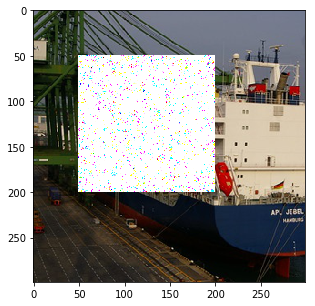

In [162]:
image_num = 0
print(imagenet_labels[500])

post_proc_adv_images = image_utils.postprocessing(ex_adv_images)
# post_proc_patch = image_utils.postprocessing(ex_naive_patch)
#image_utils.show_image(post_proc_patch)
image_utils.show_image(post_proc_adv_images[image_num])
#image_utils.show_probs(post_proc_adv_images[image_num], ex_adv_probs[image_num], imagenet_labels, target_class=300)